In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers


In [2]:
data_train_path = 'Fruits_Vegetables/train'
data_test_path = 'Fruits_Vegetables/test'
data_val_path = 'Fruits_Vegetables/validation'

In [3]:
img_width = 180
img_height =180 

In [4]:
data_train = tf.keras.utils.image_dataset_from_directory(
    data_train_path,
    shuffle=True,
    image_size=(img_width, img_height),
    batch_size=32,
    validation_split=False)

Found 3115 files belonging to 36 classes.


In [5]:
data_cat = data_train.class_names

In [6]:
data_cat

['apple',
 'banana',
 'beetroot',
 'bell pepper',
 'cabbage',
 'capsicum',
 'carrot',
 'cauliflower',
 'chilli pepper',
 'corn',
 'cucumber',
 'eggplant',
 'garlic',
 'ginger',
 'grapes',
 'jalepeno',
 'kiwi',
 'lemon',
 'lettuce',
 'mango',
 'onion',
 'orange',
 'paprika',
 'pear',
 'peas',
 'pineapple',
 'pomegranate',
 'potato',
 'raddish',
 'soy beans',
 'spinach',
 'sweetcorn',
 'sweetpotato',
 'tomato',
 'turnip',
 'watermelon']

In [7]:
data_val = tf.keras.utils.image_dataset_from_directory(data_val_path,
                                                       image_size=(img_height,img_width),
                                                       batch_size=32,
                                                        shuffle=False,
                                                       validation_split=False)

Found 351 files belonging to 36 classes.


In [8]:
data_test = tf.keras.utils.image_dataset_from_directory(
data_test_path,
    image_size=(img_height,img_width),
    shuffle=False,
    batch_size=32,
    validation_split=False
)

Found 359 files belonging to 36 classes.


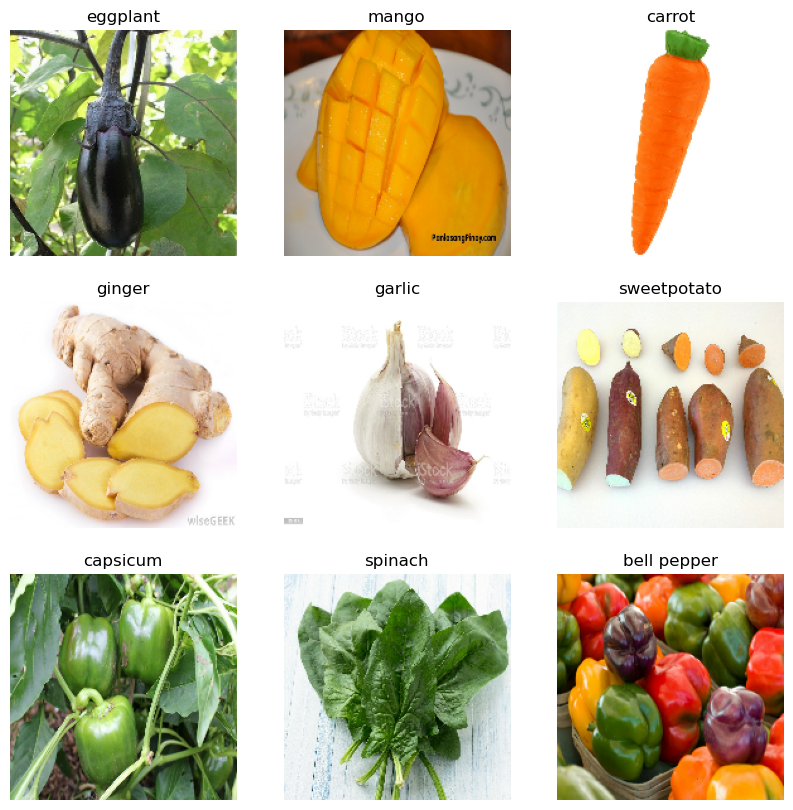

In [9]:
plt.figure(figsize=(10,10))
for image, labels in data_train.take(1):
    for i in range(9):
        plt.subplot(3,3,i+1)
        plt.imshow(image[i].numpy().astype('uint8'))
        plt.title(data_cat[labels[i]])
        plt.axis('off')

In [10]:
from tensorflow.keras.models import Sequential

In [11]:
data_train

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [12]:
model = Sequential([
    layers.Rescaling(1./255),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32,3, padding='same',activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dropout(0.2),
    layers.Dense(128),
    layers.Dense(len(data_cat))
                  
])

In [13]:
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

In [14]:
epochs_size = 25
history = model.fit(data_train, validation_data=data_val, epochs=epochs_size)

Epoch 1/25
98/98 ━━━━━━━━━━━━━━━━━━━━ 144s 1s/step - accuracy: 0.0623 - loss: 4.1080 - val_accuracy: 0.2906 - val_loss: 2.6586
Epoch 2/25
98/98 ━━━━━━━━━━━━━━━━━━━━ 98s 1s/step - accuracy: 0.2556 - loss: 2.6354 - val_accuracy: 0.5613 - val_loss: 1.5045
Epoch 3/25
98/98 ━━━━━━━━━━━━━━━━━━━━ 111s 1s/step - accuracy: 0.4577 - loss: 1.8655 - val_accuracy: 0.7835 - val_loss: 0.8323
Epoch 4/25
98/98 ━━━━━━━━━━━━━━━━━━━━ 100s 1s/step - accuracy: 0.6613 - loss: 1.1627 - val_accuracy: 0.8946 - val_loss: 0.5668
Epoch 5/25
98/98 ━━━━━━━━━━━━━━━━━━━━ 199s 2s/step - accuracy: 0.8362 - loss: 0.6206 - val_accuracy: 0.9145 - val_loss: 0.4617
Epoch 6/25
98/98 ━━━━━━━━━━━━━━━━━━━━ 175s 2s/step - accuracy: 0.8960 - loss: 0.4239 - val_accuracy: 0.9373 - val_loss: 0.3438
Epoch 7/25
98/98 ━━━━━━━━━━━━━━━━━━━━ 123s 1s/step - accuracy: 0.9405 - loss: 0.2212 - val_accuracy: 0.9487 - val_loss: 0.4763
Epoch 8/25
98/98 ━━━━━━━━━━━━━━━━━━━━ 95s 959ms/step - accuracy: 0.9504 - loss: 0.2202 - val_accuracy: 0.9487 - 

Text(0.5, 1.0, 'Loss')

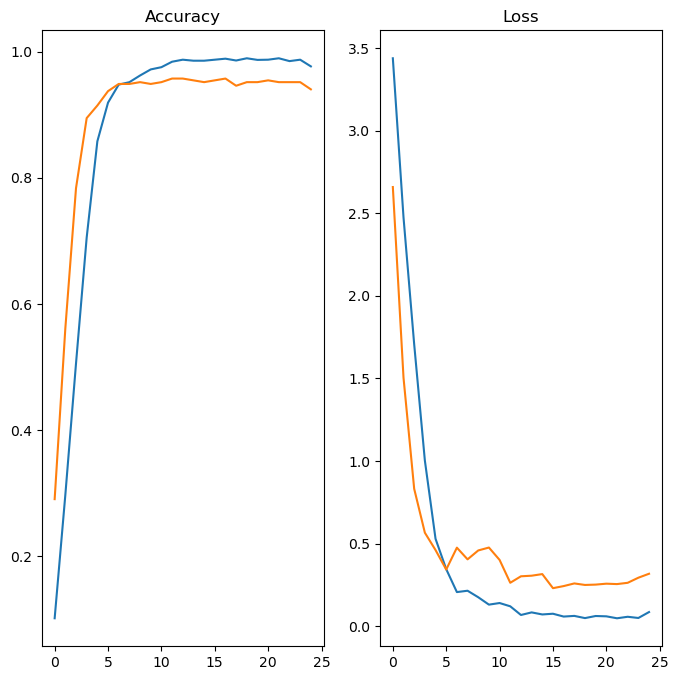

In [15]:
epochs_range = range(epochs_size)
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(epochs_range,history.history['accuracy'],label = 'Training Accuracy')
plt.plot(epochs_range, history.history['val_accuracy'],label = 'Validation Accuracy')
plt.title('Accuracy')

plt.subplot(1,2,2)
plt.plot(epochs_range,history.history['loss'],label = 'Training Loss')
plt.plot(epochs_range, history.history['val_loss'],label = 'Validation Loss')
plt.title('Loss')

In [26]:
image = 'Sample/Apple.jpg'
image = tf.keras.utils.load_img(image, target_size=(img_height,img_width))
img_arr = tf.keras.utils.array_to_img(image)
img_bat=tf.expand_dims(img_arr,0)

In [28]:
predict = model.predict(img_bat)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


In [30]:
score = tf.nn.softmax(predict)

In [32]:
print('Veg/Fruit in image is {} with accuracy of {:0.2f}'.format(data_cat[np.argmax(score)],np.max(score)*100))

Veg/Fruit in image is apple with accuracy of 100.00


In [34]:
model.save('Image_classify.keras')